In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from copy import deepcopy
import pickle

import jax
import jax.numpy as jnp
from jax import jit, lax, grad, value_and_grad, vmap
import optax
import tensorflow as tf
import tensorflow_datasets as tfds

import jaxley as jx
from jaxley.channels import HH
from jaxley.synapses import IonotropicSynapse
from jaxley.utils.colors import network_cols

In [5]:
nseg_per_branch = 2

i_delay = 10.0  # ms
i_amp = 0.1  # nA
i_dur = 150.0  # ms
dt = 0.025  # ms
t_max = 199.9  # ms

### Visualize trace

In [6]:
time_vec = np.arange(0, 199+2*dt, dt)

In [7]:
names = []
for x in os.walk("../../../nex/ca1net/morphologies"):
    if len(x[0]) < 40 and len(x[0]) > 32:
        names.append(x[0])
        fnames = [f"{n}/{n[-4:]}.CNG.swc" for n in names]

In [8]:
cells = []
for fname in fnames:
    cell = jx.read_swc(fname, nseg_per_branch, max_branch_len=500.0)
    if cell.total_nbranches < 280:
        cells.append(cell)

size_factor = 1  # 40
sf = size_factor  # abbreviate
all_cells = []
for _ in range(size_factor):
    all_cells = all_cells + cells

all_cells = all_cells + [cells[0]]
cells = all_cells
print("Number of cells: ", len(cells))

Number of cells:  51


In [9]:
all_nbranches = []
all_levels = []
for cell in cells:
    all_nbranches.append(cell.total_nbranches)
    all_levels.append(len(cell.parents_in_level))

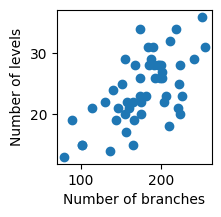

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
_ = ax.scatter(all_nbranches, all_levels)
_ = ax.set_xlabel("Number of branches")
_ = ax.set_ylabel("Number of levels")
plt.show()

In [25]:
states_per_compartment = 4  # v, m, n, h
n_syn = 1_020_000
n_states_per_syn = 1
print("total number of states (million): ", (np.sum(all_nbranches) * 40 * nseg_per_branch * states_per_compartment + n_syn * n_states_per_syn) / 1e6)

total number of states (million):  3.93008


In [11]:
cols = network_cols([10*sf, 10*sf, 10*sf, 10*sf, 10*sf, 1])
time_vec = jnp.arange(0.0, t_max+dt, dt)

In [13]:
from jaxley.connection import sparse_connect, fully_connect

In [14]:
# network = jx.Network(cells)
# print("Initialized network")

# _ = np.random.seed(0)  # location of post synapse is random.

# pre = network.cell(np.arange(0*sf, 13*sf).tolist())
# post = network.cell(np.arange(13*sf, 26*sf).tolist())
# fully_connect(pre, post, IonotropicSynapse())
# print("Fist layer done")

# pre = network.cell(np.arange(13*sf, 26*sf).tolist())
# post = network.cell(np.arange(26*sf, 39*sf).tolist())
# fully_connect(pre, post, IonotropicSynapse())
# print("Second layer done")

# pre = network.cell(np.arange(26*sf, 39*sf).tolist())
# post = network.cell(np.arange(39*sf, 50*sf).tolist())
# fully_connect(pre, post, IonotropicSynapse())
# print("Third layer done")

# pre = network.cell(np.arange(39*sf, 50*sf).tolist())
# post = network.cell(50*sf)
# fully_connect(pre, post, IonotropicSynapse())

In [15]:
network = jx.Network(cells)
print("Initialized network")

_ = np.random.seed(0)  # location of post synapse is random.

pre = network.cell(np.arange(0*sf, 10*sf).tolist())
post = network.cell(np.arange(10*sf, 20*sf).tolist())
fully_connect(pre, post, IonotropicSynapse())
sparse_connect(pre, post, IonotropicSynapse(), 0.58)
print("First layer done")

pre = network.cell(np.arange(10*sf, 20*sf).tolist())
post = network.cell(np.arange(20*sf, 30*sf).tolist())
fully_connect(pre, post, IonotropicSynapse())
sparse_connect(pre, post, IonotropicSynapse(), 0.58)
print("Second layer done")

pre = network.cell(np.arange(20*sf, 30*sf).tolist())
post = network.cell(np.arange(30*sf, 40*sf).tolist())
fully_connect(pre, post, IonotropicSynapse())
sparse_connect(pre, post, IonotropicSynapse(), 0.58)
print("Third layer done")

pre = network.cell(np.arange(30*sf, 40*sf).tolist())
post = network.cell(np.arange(40*sf, 50*sf).tolist())
fully_connect(pre, post, IonotropicSynapse())
sparse_connect(pre, post, IonotropicSynapse(), 0.58)
print("Forth layer done")

pre = network.cell(np.arange(40*sf, 50*sf).tolist())
post = network.cell(50*sf)
fully_connect(pre, post, IonotropicSynapse())

Initialized network


/home/rocky/Documents/jaxley/jaxley/modules/base.py:1766: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.pointer.edges = pd.concat(


First layer done
Second layer done
Third layer done
Forth layer done


In [16]:
num_synapses = len(network.edges)
print(f"Number of synapses: {num_synapses}")

Number of synapses: 1011630


In [17]:
num_synapses = len(network.edges)
print(f"Number of synapses: {num_synapses}")

Number of synapses: 1011630


### Visualize

In [20]:
timesteps = (t_max + 0.05) / dt
levels = 3
checkpoints = [int(np.ceil(timesteps**(1/levels))) for _ in range(levels)]
print(f"Timesteps {int(timesteps)}, num run {np.prod(checkpoints)}, memory {np.sum(checkpoints)}, reduction {int(timesteps) / np.sum(checkpoints)}")

Timesteps 7998, num run 8000, memory 60, reduction 133.3


In [21]:
network.IonotropicSynapse.set("IonotropicSynapse_gS", 0.00003 / sf * 20)
network.IonotropicSynapse(np.arange(num_synapses - 10 * sf, num_synapses).tolist()).set("IonotropicSynapse_gS", 0.0001 / sf * 20)
network.IonotropicSynapse.set("IonotropicSynapse_s", 0.0)

In [22]:
network.delete_recordings()
network.delete_stimuli()

for cell_ind in range(len(cells)):
    network.cell(cell_ind).branch(1).comp(0).record(verbose=False)

In [23]:
network.insert(HH())
network.set("v", -65.0)
network.init_states()

The sf=20 model has a computation graph of 1.84 TB.

In [24]:
def simulate(params, currents):
    data_stimuli = None
    currents = jx.datapoint_to_step_currents(i_delay, i_dur, currents, dt, t_max)
    for current, cell_ind in zip(currents, range(10 * sf)):
        data_stimuli = network.cell(cell_ind).branch(1).comp(0).data_stimulate(current, data_stimuli=data_stimuli)

    return jx.integrate(network, data_stimuli=data_stimuli, params=params, checkpoint_lengths=checkpoints)

jitted_simulate = jit(simulate)

In [25]:
start_time = time.time()
s_net = jitted_simulate([], i_amp * jnp.asarray(np.random.rand(10 * sf)))
print("Time", time.time() - start_time)

2024-08-01 10:45:07.689634: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %pad.404 = s32[357836,2]{1,0} pad(s32[357836,1]{1,0} %constant.5664, s32[] %constant.5666), padding=0_0x0_1, metadata={op_name="jit(simulate)/jit(main)/concatenate[dimension=1]" source_file="/home/rocky/Documents/jaxley/jaxley/modules/cell.py" source_line=262}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-08-01 10:45:07.905392: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.215799758s
Constant folding an instruction is taking > 1s:

  %pad.404 = s32[357836,2]{1,0} pad(s32

Time 198.53613591194153


In [26]:
_ = np.random.seed(0)
start_time = time.time()
s_net = jitted_simulate([], 2 * i_amp * jnp.asarray(np.random.rand(10 * sf)))
print("Time", time.time() - start_time)

Time 21.062547206878662


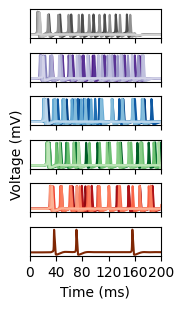

In [27]:
fig, ax = plt.subplots(6, 1, figsize=(1.7, 3.2))
for i in np.arange(0, len(s_net), 40):
    if i < sf * 10:
        layer = 0
    elif i < sf * 20:
        layer = 1
    elif i < sf * 30:
        layer = 2
    elif i < sf * 40:
        layer = 3
    elif i < sf * 50:
        layer = 4
    else:
        layer = 5
    _ = ax[layer].plot(time_vec, s_net[i, :-1], c=cols[i])
ax[layer].set_xlabel("")
ax[layer].set_xlim([0, max(time_vec)])
ax[layer].set_xlabel("Time (ms)")
ax[3].set_ylabel("Voltage (mV)")
for i in range(6):
    ax[i].set_ylim([-80, 50])
    ax[i].set_yticks([])
    ax[i].set_xticks([0, 40, 80, 120, 160, 200])
    ax[i].set_xlim([0, 200])
for i in range(5):
    ax[i].set_xticklabels([])
plt.subplots_adjust(hspace=0.5)
plt.show()

In [29]:
with open("../results/02_large_scale/voltages.pkl", "wb") as handle:
    pickle.dump(s_net, handle)

### Optimization setup

In [31]:
network.delete_trainables()

network.cell("all").branch("all").comp("all").make_trainable("HH_gNa", verbose=True)
network.cell("all").branch("all").comp("all").make_trainable("HH_gK", verbose=True)
network.cell("all").branch("all").comp("all").make_trainable("HH_gLeak", verbose=True)
# network.cell("all").branch("all").comp("all").make_trainable("axial_resistivity", verbose=True)
network.IonotropicSynapse("all").make_trainable("IonotropicSynapse_gS", verbose=True)

Number of newly added trainable parameters: 719674. Total number of trainable parameters: 719674
Number of newly added trainable parameters: 719674. Total number of trainable parameters: 1439348
Number of newly added trainable parameters: 719674. Total number of trainable parameters: 2159022
Number of newly added trainable parameters: 1011630. Total number of trainable parameters: 3170652


In [32]:
dim = 10 * sf
image = 2 * i_amp * jnp.ones((10 * sf,))

In [33]:
params = network.get_parameters()

### Define loss

In [34]:
def predict(params, image):
    voltages = simulate(params, image)
    return voltages[-1, -1]  # Output neuron last voltage.

jitted_predict = jit(predict)


def loss_fn(params, image):
    prediction = predict(params, image)
    return jnp.mean(prediction)

loss_grad = jit(value_and_grad(loss_fn, argnums=0))

### Compute gradient

In [35]:
start_time = time.time()
loss, grad = loss_grad(params, image)
print("Time", time.time() - start_time)

2024-08-01 10:15:54.737110: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 2s:

  %compare.634 = pred[719674,1]{1,0} compare(s64[719674,1]{1,0} %constant.118, s64[719674,1]{1,0} %broadcast.80), direction=LT, metadata={op_name="jit(loss_fn)/jit(main)/lt" source_file="/home/rocky/Documents/jaxley/jaxley/modules/base.py" source_line=521}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-08-01 10:15:55.334852: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.597806603s
Constant folding an instruction is taking > 2s:

  %compare.634 = pred[719674,1]{1,0} compare(

Time 661.12668633461


In [36]:
test_image = 1.01 * i_amp * jnp.ones((10 * sf,))

In [37]:
start_time = time.time()
loss, grad = loss_grad(params, test_image)
print("Time", time.time() - start_time)

Time 144.64973187446594
